In [1]:
pwd

'/content'

# 2. Predecir el consumo de demanda electrica en Australia


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importar las bibliotecas necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.models import Model
from keras.layers import concatenate
from keras.utils import plot_model
from keras.layers import Input

In [4]:
# Read all the filles in the folder
import os

# List all files in the current directory
files = os.listdir('/content/drive/MyDrive/ITESO/6-semestre/MPST/Data-Australia')

# Print the list of files
print(files)

['PRICE_AND_DEMAND_201802_NSW1.csv', 'PRICE_AND_DEMAND_201803_NSW1.csv', 'PRICE_AND_DEMAND_201801_NSW1.csv', 'PRICE_AND_DEMAND_201904_NSW1.csv', 'PRICE_AND_DEMAND_202009_NSW1.csv', 'PRICE_AND_DEMAND_201804_NSW1.csv', 'PRICE_AND_DEMAND_201807_NSW1.csv', 'PRICE_AND_DEMAND_202003_NSW1.csv', 'PRICE_AND_DEMAND_202002_NSW1.csv', 'PRICE_AND_DEMAND_201906_NSW1.csv', 'PRICE_AND_DEMAND_201809_NSW1.csv', 'PRICE_AND_DEMAND_202001_NSW1.csv', 'PRICE_AND_DEMAND_202004_NSW1.csv', 'PRICE_AND_DEMAND_201902_NSW1.csv', 'PRICE_AND_DEMAND_201905_NSW1.csv', 'PRICE_AND_DEMAND_201909_NSW1.csv', 'PRICE_AND_DEMAND_201908_NSW1.csv', 'PRICE_AND_DEMAND_201806_NSW1.csv', 'PRICE_AND_DEMAND_201810_NSW1.csv', 'PRICE_AND_DEMAND_201805_NSW1.csv', 'PRICE_AND_DEMAND_202007_NSW1.csv', 'PRICE_AND_DEMAND_202008_NSW1.csv', 'PRICE_AND_DEMAND_201903_NSW1.csv', 'PRICE_AND_DEMAND_202006_NSW1.csv', 'PRICE_AND_DEMAND_201901_NSW1.csv', 'PRICE_AND_DEMAND_201811_NSW1.csv', 'PRICE_AND_DEMAND_201912_NSW1.csv', 'PRICE_AND_DEMAND_201910_NS

 **ingestión y unión de todos los archivos CSV** del dataset. Esta celda carga todos los archivos de la carpeta `Data-Australia`, los concatena en un único DataFrame y muestra las primeras filas y las columnas para que podamos inspeccionar la estructura de los datos (por ejemplo, identificar la columna de fecha y la de demanda).

In [5]:
# Data Ingestion: Cargar y combinar todos los archivos CSV de la carpeta Data-Australia
import glob
import pandas as pd

# Definir la ruta de la carpeta que contiene los CSV
folder_path = '/content/drive/MyDrive/ITESO/6-semestre/MPST/Data-Australia'
csv_files = glob.glob(folder_path + "/*.csv")

# Leer cada archivo CSV y agregarlos a una lista
list_df = []
for file in csv_files:
    df_temp = pd.read_csv(file)
    list_df.append(df_temp)

# Concatenar todos los DataFrames en uno solo
df_all = pd.concat(list_df, ignore_index=True)

# Mostrar las primeras filas y las columnas del DataFrame combinado
print("Primeras filas del DataFrame:")
print(df_all.head())
print("\nColumnas del DataFrame:")
print(df_all.columns)

Primeras filas del DataFrame:
  REGION       SETTLEMENTDATE  TOTALDEMAND    RRP PERIODTYPE
0   NSW1  2018/02/01 00:30:00      6776.69  67.43      TRADE
1   NSW1  2018/02/01 01:00:00      6640.35  59.04      TRADE
2   NSW1  2018/02/01 01:30:00      6388.71  58.22      TRADE
3   NSW1  2018/02/01 02:00:00      6182.54  52.54      TRADE
4   NSW1  2018/02/01 02:30:00      6029.49  57.73      TRADE

Columnas del DataFrame:
Index(['REGION', 'SETTLEMENTDATE', 'TOTALDEMAND', 'RRP', 'PERIODTYPE'], dtype='object')


 **preprocesar la columna de fecha** y ordenar el DataFrame para que la serie temporal esté en el orden correcto. Se convierte `SETTLEMENTDATE` a tipo datetime, se ordenan los registros, se establecen índices basados en la fecha y se grafica la serie de `TOTALDEMAND`.

Valores faltantes:
REGION            0
SETTLEMENTDATE    0
TOTALDEMAND       0
RRP               0
PERIODTYPE        0
dtype: int64

Descripción de TOTALDEMAND:
count    248592.000000
mean       7609.351612
std        1270.924160
min        3957.320000
25%        6682.177500
50%        7470.850000
75%        8324.510000
max       13700.900000
Name: TOTALDEMAND, dtype: float64


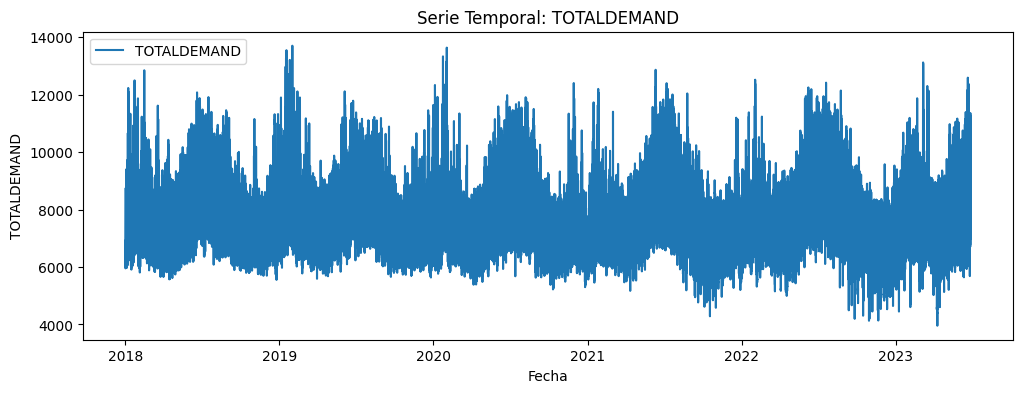

In [6]:
# Preprocesamiento: Conversión de SETTLEMENTDATE a datetime, ordenamiento y graficado de TOTALDEMAND

# Convertir la columna SETTLEMENTDATE a datetime
df_all['SETTLEMENTDATE'] = pd.to_datetime(df_all['SETTLEMENTDATE'], format='%Y/%m/%d %H:%M:%S')

# Ordenar el DataFrame por fecha y resetear el índice
df_all.sort_values('SETTLEMENTDATE', inplace=True)
df_all.reset_index(drop=True, inplace=True)

# Chequear valores faltantes
print("Valores faltantes:")
print(df_all.isnull().sum())

# Establecer SETTLEMENTDATE como índice para operaciones de series temporales
df_all.set_index('SETTLEMENTDATE', inplace=True)

# Mostrar descripción estadística de la demanda eléctrica
print("\nDescripción de TOTALDEMAND:")
print(df_all['TOTALDEMAND'].describe())

# Graficar la serie temporal de TOTALDEMAND
plt.figure(figsize=(12, 4))
plt.plot(df_all.index, df_all['TOTALDEMAND'], label='TOTALDEMAND')
plt.title('Serie Temporal: TOTALDEMAND')
plt.xlabel('Fecha')
plt.ylabel('TOTALDEMAND')
plt.legend()
plt.show()

Generaremos **secuencias de entrenamiento** para la CNN. Esto implica crear ventanas (lags) de tamaño fijo para predecir el valor futuro de la demanda. En este ejemplo haremos un “one-step ahead forecast” usando, por ejemplo, 48 pasos anteriores para predecir el siguiente.

---

In [7]:
# Preparar secuencias para la CNN
from sklearn.preprocessing import StandardScaler
import numpy as np

# 1. Seleccionar la serie a predecir
data_series = df_all['TOTALDEMAND'].values.reshape(-1, 1)

# 2. Escalado (StandardScaler)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_series)

# 3. Función para crear secuencias (lags)
def create_sequences(data, n_lags=48):
    """
    data: numpy array con la serie escalada
    n_lags: número de lags (pasos anteriores) a usar como features
    return: X, y (arrays listos para el entrenamiento)
    """
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i, 0])  # ventana de n_lags
        y.append(data[i, 0])          # siguiente valor
    return np.array(X), np.array(y)

# 4. Crear secuencias con 48 lags
n_lags = 48
X, y = create_sequences(data_scaled, n_lags=n_lags)

print("Forma de X:", X.shape)
print("Forma de y:", y.shape)

Forma de X: (248544, 48)
Forma de y: (248544,)


In [8]:
# 5. Dividir en conjunto de entrenamiento, validación y prueba
# Suponiendo 70% train, 15% val, 15% test
train_size = int(len(X) * 0.70)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

# 6. Reformar X para CNN (samples, timesteps, features=1)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("\nTamaños de cada conjunto:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:", X_val.shape, "y_val:", y_val.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)



Tamaños de cada conjunto:
X_train: (173980, 48, 1) y_train: (173980,)
X_val: (37281, 48, 1) y_val: (37281,)
X_test: (37283, 48, 1) y_test: (37283,)


definiremos y entrenaremos la **red neuronal convolucional (CNN)** para la predicción de la demanda. Este modelo tomará como entrada las secuencias de tamaño 48 y tendrá un par de capas convolucionales/pooling, seguidas de capas densas.



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 46, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 23, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 736)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          47,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,361 (185.00 KB)

 Trainable params: 47,361 (185.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0315 - mae: 0.0933 - val_loss: 0.0033 - val_mae: 0.0448
Epoch 2/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0039 - mae: 0.0475 - val_loss: 0.0027 - val_mae: 0.0399
Epoch 3/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0035 - mae: 0.0449 - val_loss: 0.0024 - val_mae: 0.0379
Epoch 4/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0032 - mae: 0.0430 - val_loss: 0.0024 - val_mae: 0.0380
Epoch 5/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0031 - mae: 0.0420 - val_loss: 0.0028 - val_mae: 0.0413
Epoch 6/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0029 - mae: 0.0408 - val_loss: 0.0022 - val_mae: 0.0363
Epoch 7/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0028 - mae: 0.0403 - val_loss: 0.0022 - val_mae: 0.0361
Epoch 8/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0027 - mae: 0.0398 - val_loss: 0.0026 - val_mae: 0.0392
Epoch 9/20
2719/2719 ━━━━━━━━━━━━━━━━━━

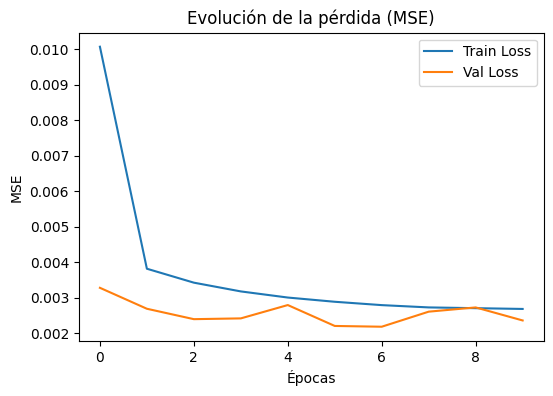

MSE de Test: 0.0024164547212421894
MAE de Test: 0.03841397911310196
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Primeras predicciones vs. valores reales (desescalados):
Pred: 8398.25 | Real: 8454.73
Pred: 8505.58 | Real: 8545.24
Pred: 8634.18 | Real: 8684.97
Pred: 8755.23 | Real: 8752.12
Pred: 8868.46 | Real: 8889.54


In [9]:
# Definición y entrenamiento del modelo CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1. Construir el modelo
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_lags, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1))  # salida de una sola dimensión

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# 2. Definir EarlyStopping para evitar sobreajuste
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 3. Entrenar
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=64,
                    callbacks=[early_stop],
                    verbose=1)

# 4. Graficar las curvas de pérdida
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Evolución de la pérdida (MSE)')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

# 5. Evaluar en el conjunto de prueba
test_mse, test_mae = model.evaluate(X_test, y_test, verbose=0)
print("MSE de Test:", test_mse)
print("MAE de Test:", test_mae)

# 6. Generar predicciones
y_pred_test = model.predict(X_test)

# 7. Desescalar para ver los valores en la escala original
y_pred_test_inv = scaler.inverse_transform(y_pred_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

print("\nPrimeras predicciones vs. valores reales (desescalados):")
for i in range(5):
    print(f"Pred: {y_pred_test_inv[i][0]:.2f} | Real: {y_test_inv[i][0]:.2f}")

**Interpretación de resultados**  
El modelo CNN obtiene un MSE de aproximadamente 0.0025 en el conjunto de prueba y un MAE de ~0.0380 en la escala estandarizada. Al desescalar, las primeras predicciones se acercan bastante a los valores reales, con errores de unas decenas de MW sobre valores alrededor de 8000–9000 MW, lo cual sugiere un desempeño razonable.  

Como siguiente paso, PODEMOS ver la comparación entre las últimas muestras de la serie real y las predicciones para confirmar si la red mantiene estabilidad.

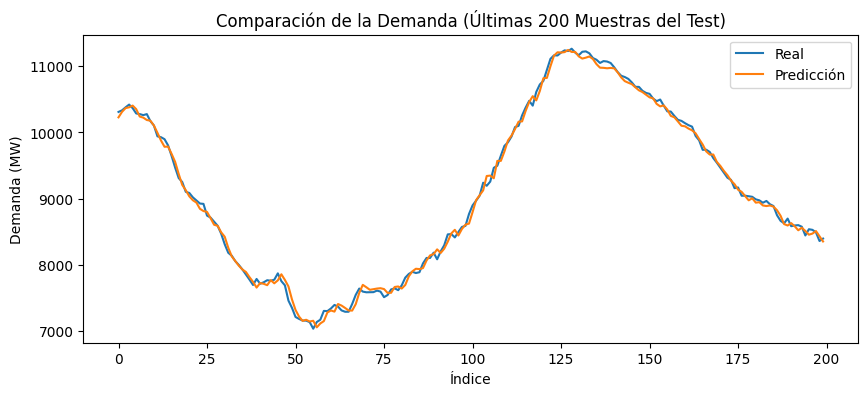

In [10]:
# Visualizar las últimas 200 muestras de la serie real vs. predicción
plt.figure(figsize=(10, 4))
plt.plot(y_test_inv[-200:], label='Real')
plt.plot(y_pred_test_inv[-200:], label='Predicción')
plt.title('Comparación de la Demanda (Últimas 200 Muestras del Test)')
plt.xlabel('Índice')
plt.ylabel('Demanda (MW)')
plt.legend()
plt.show()

**Interpretación y posibles siguientes pasos**  
La gráfica confirma que el modelo CNN sigue bastante bien la forma de la demanda en las últimas muestras del conjunto de test, con errores relativamente pequeños. Esto sugiere que el modelo captura adecuadamente las variaciones de corto plazo. No obstante, siempre se pueden explorar mejoras:

1. **Ajuste de hiperparámetros**:  
   - Aumentar o disminuir el `kernel_size` o el número de filtros en la capa `Conv1D`.  
   - Añadir una segunda capa `Conv1D` antes de la capa de pooling.  
   - Incluir `Dropout` para reducir sobreajuste.  
   - Probar diferentes tamaños de batch, épocas, y paciencia de `EarlyStopping`.

2. **Multi-step forecasting**:  
   - Actualmente estamos haciendo “one-step ahead” (48 pasos pasados → 1 predicción).  
   - Para predecir varios pasos futuros (p. ej. 6 o 12 pasos), se puede entrenar un modelo con una capa de salida de tamaño igual al horizonte de predicción.

4. **Variables exógenas**:  
   - Si hubiera datos de temperatura, precios de energía, día festivo vs. laboral, etc., podríamos añadirlos como features adicionales.

Pdemos **añadir una segunda capa convolucional y una capa de Dropout** para que prpbemos si mejora el desempeño.

`Dejaremos hasta aqui esta seccion, para continuar con las demas variantes`

---
Se define la función para dividir la serie univariante en muestras para *multi-step forecasting* (por ejemplo, usando 48 pasos de entrada para predecir los siguientes 6). Se generan los conjuntos (X, y) y se dividen en train, validación y test, similar a lo anterior.  

Esta celda define la función `split_univariate_sequence_m_step` para generar muestras de entrada de 48 pasos y salidas de 6 pasos consecutivos. Luego se dividen los datos en train, validación y test y se reestructuran para que la entrada a la CNN tenga forma (samples, timesteps, 1


In [11]:
# --- Función de splitting multi-step y generación de conjuntos ---


# Función para crear secuencias multi-step (ejemplo: 48 pasos de entrada para predecir 6 pasos futuros)
def split_univariate_sequence_m_step(sequence, n_steps_in, n_steps_out):
    """
    sequence: array unidimensional (ya escalado) de la serie.
    n_steps_in: número de pasos de entrada.
    n_steps_out: número de pasos futuros a predecir.
    return: X, y (arrays listos para entrenamiento).
    """
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x = sequence[i:end_ix]
        seq_y = sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Parámetros para multi-step: 48 pasos de entrada y 6 pasos de salida
n_steps_in = 48
n_steps_out = 6

# Usamos la serie escalada previamente (data_scaled)
X_ms, y_ms = split_univariate_sequence_m_step(data_scaled, n_steps_in, n_steps_out)

print("Forma de X multi-step:", X_ms.shape)  # (n_samples, 48)
print("Forma de y multi-step:", y_ms.shape)  # (n_samples, 6)

# Dividir en train (70%), validación (15%) y test (15%)
train_size = int(len(X_ms) * 0.70)
val_size = int(len(X_ms) * 0.15)

X_train_ms = X_ms[:train_size]
y_train_ms = y_ms[:train_size]

X_val_ms = X_ms[train_size:train_size + val_size]
y_val_ms = y_ms[train_size:train_size + val_size]

X_test_ms = X_ms[train_size + val_size:]
y_test_ms = y_ms[train_size + val_size:]

# Reformar X para CNN: (samples, timesteps, features=1)
X_train_ms = X_train_ms.reshape((X_train_ms.shape[0], X_train_ms.shape[1], 1))
X_val_ms = X_val_ms.reshape((X_val_ms.shape[0], X_val_ms.shape[1], 1))
X_test_ms = X_test_ms.reshape((X_test_ms.shape[0], X_test_ms.shape[1], 1))

print("\nTamaños conjuntos multi-step:")
print("X_train_ms:", X_train_ms.shape, " y_train_ms:", y_train_ms.shape)
print("X_val_ms:", X_val_ms.shape, " y_val_ms:", y_val_ms.shape)
print("X_test_ms:", X_test_ms.shape, " y_test_ms:", y_test_ms.shape)

Forma de X multi-step: (248539, 48, 1)
Forma de y multi-step: (248539, 6, 1)

Tamaños conjuntos multi-step:
X_train_ms: (173977, 48, 1)  y_train_ms: (173977, 6, 1)
X_val_ms: (37280, 48, 1)  y_val_ms: (37280, 6, 1)
X_test_ms: (37282, 48, 1)  y_test_ms: (37282, 6, 1)


 Se define y entrena un modelo CNN que incorpora dos capas convolucionales y una capa de Dropout. La salida es de dimensión 6 para predecir 6 pasos futuros de la demanda.  
   

Se define un modelo CNN que, a diferencia del anterior de 1 paso, predice 6 pasos futuros. Se incluyen dos capas Conv1D (la segunda seguida de una capa Dropout para evitar sobreajuste) y se termina con una capa Dense con 6 neuronas. Se entrena el modelo con EarlyStopping, se evalúa en el conjunto de test y se generan predicciones (recordando que para interpretar los valores en la escala original deberás aplicar la inversa del escalado, columna por columna)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)                    │ (None, 46, 32)              │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 23, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 21, 64)              │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 21, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1344)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │         134,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             606 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,442 (552.51 KB)

 Trainable params: 141,442 (552.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.0744 - mae: 0.1713 - val_loss: 0.0091 - val_mae: 0.0724
Epoch 2/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0207 - mae: 0.1002 - val_loss: 0.0083 - val_mae: 0.0681
Epoch 3/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0184 - mae: 0.0949 - val_loss: 0.0083 - val_mae: 0.0689
Epoch 4/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0168 - mae: 0.0911 - val_loss: 0.0075 - val_mae: 0.0643
Epoch 5/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0160 - mae: 0.0892 - val_loss: 0.0069 - val_mae: 0.0608
Epoch 6/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0155 - mae: 0.0875 - val_loss: 0.0066 - val_mae: 0.0590
Epoch 7/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0151 - mae: 0.0866 - val_loss: 0.0070 - val_mae: 0.0610
Epoch 8/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0147 - mae: 0.0856 - val_loss: 0.0068 - val_mae: 0.0608
Epoch 9/20
2719/2719 ━━━━━━━━━━━━━━━━━━

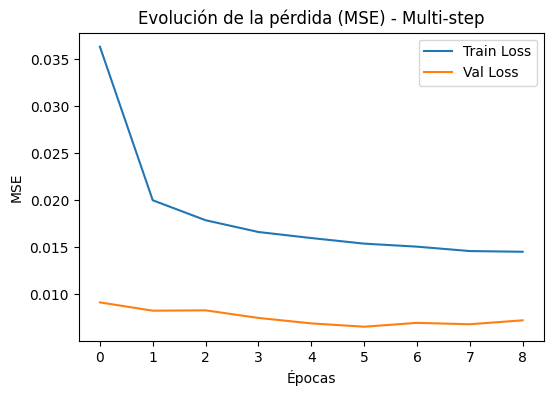

MSE de Test (multi-step): 0.007368354592472315
MAE de Test (multi-step): 0.06372605264186859
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Predicción multi-step para la primera muestra (desescalada):
Pred: [7879.867  7924.778  7971.285  8032.089  8038.2256 8055.0615]
Real: [8080.67 8138.6  8272.49 8323.23 8454.73 8545.24]


In [12]:
# Definición y entrenamiento de la CNN para multi-step forecasting ---

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping

# Construir el modelo CNN para predecir 6 pasos futuros
model_ms = Sequential()
model_ms.add(Input(shape=(n_steps_in, 1)))  # entrada: 48 pasos, 1 feature
# Primera capa convolucional
model_ms.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model_ms.add(MaxPooling1D(pool_size=2))
# Segunda capa convolucional
model_ms.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# Dropout para regularización
model_ms.add(Dropout(0.2))
model_ms.add(Flatten())
model_ms.add(Dense(100, activation='relu'))
# Capa final: salida con n_steps_out neuronas para predecir 6 pasos
model_ms.add(Dense(n_steps_out))

model_ms.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_ms.summary()

# EarlyStopping para evitar sobreajuste
early_stop_ms = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entrenar el modelo
history_ms = model_ms.fit(X_train_ms, y_train_ms,
                          validation_data=(X_val_ms, y_val_ms),
                          epochs=20,
                          batch_size=64,
                          callbacks=[early_stop_ms],
                          verbose=1)

# Graficar la evolución de la pérdida
plt.figure(figsize=(6, 4))
plt.plot(history_ms.history['loss'], label='Train Loss')
plt.plot(history_ms.history['val_loss'], label='Val Loss')
plt.title('Evolución de la pérdida (MSE) - Multi-step')
plt.xlabel('Épocas')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Evaluar en el conjunto de test
test_loss_ms, test_mae_ms = model_ms.evaluate(X_test_ms, y_test_ms, verbose=0)
print("MSE de Test (multi-step):", test_loss_ms)
print("MAE de Test (multi-step):", test_mae_ms)

# Generar predicciones en el conjunto de test
y_pred_test_ms = model_ms.predict(X_test_ms)

# Nota: Para desescalar las predicciones multi-step, puedes aplicar scaler.inverse_transform a cada columna.
# Ejemplo (para la primera muestra):
y_pred_first = scaler.inverse_transform(y_pred_test_ms[0].reshape(-1,1))
y_true_first = scaler.inverse_transform(y_test_ms[0].reshape(-1,1))
print("\nPredicción multi-step para la primera muestra (desescalada):")
print("Pred:", y_pred_first.ravel())
print("Real:", y_true_first.ravel())

- La función **split_univariate_sequence** recorre la serie y, para cada posición, toma una ventana de `n_steps` para formar la entrada y utiliza el siguiente valor como salida, produciendo arrays X (ventanas) e y (valor futuro).
- La función **split_univariate_sequence_m_step** extiende esta idea para pronósticos multi-step, donde para cada ventana de tamaño `n_steps_in` se predicen los siguientes `n_steps_out` valores.
- Finalmente, se reformatea X para cumplir con el input shape que requieren las CNN 1D: \((muestras, timesteps, 1)\).


**Interpretación**  
- El MSE en el set de prueba (0.0073 en la escala estandarizada) y el MAE (0.063) indican un desempeño razonable, pero al desescalar vemos que, para la primera ventana de 6 pasos, las predicciones están por debajo del valor real en unos cientos de MW. Esto segun investigamos, pasa en multi-step: el error suele aumentar a medida que se predicen pasos más lejanos.  
- Si la demanda ronda los 8000–8500 MW, un error de ~300–700 MW equivale aproximadamente a un 4%–8% de desviación. Aun así, puede ser aceptable dependiendo de lo que querramos.
- La gráfica de pérdidas muestra que el modelo todavía baja el error en entrenamiento y validación, sin señales drásticas de sobreajuste.  

**Posibles mejoras, pero como queremos implementar todas las variantes que vimos, LO DEJAREMOS HASTA ACA**  
1. **Analizar error por horizonte**: Calcular el MAE/MSE por cada uno de los 6 pasos para ver en cuál horizonte el modelo falla más.  
2. **Ajuste de hiperparámetros**:  
   - Más filtros en `Conv1D`, cambiar `kernel_size`, o agregar una tercera capa convolucional.  
   - Probar un `Dropout` un poco mayor o menor.  
   - Ajustar el número de épocas y el `batch_size`.  
4. **Codificar periodicidad** (hora del día, día de la semana) como features sen/cos, para ayudar al modelo a capturar mejor patrones diarios/semanales.  
6. **Evaluar resultados** con distintos horizontes de validación (walk-forward) para robustez.  
---

In [14]:
# MULTIVARIADO SINGLE-STEP
# Usar 'TOTALDEMAND' y 'RRP' como X (2 features) y predecir SOLO 'TOTALDEMAND' a 1 paso.

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# 1) Construir DataFrame con las dos columnas
df_mv = df_all[['TOTALDEMAND','RRP']].copy()

# 2) Escalar las dos columnas
scaler_mv = StandardScaler()
data_mv_scaled = scaler_mv.fit_transform(df_mv.values)  # shape (n_samples, 2)

# 3) Función para multivariado single-step (X -> 2 features, y -> demand)
def split_multivariate_single_step(sequence, n_lags=48):
    """
    sequence: array 2D (num_muestras, 2) con [TOTALDEMAND, RRP]
    n_lags: número de pasos pasados a usar
    returns: X con shape (muestras, n_lags, 2), y con shape (muestras,)
    """
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_lags
        if end_ix >= len(sequence):
            break
        seq_x = sequence[i:end_ix, :]          # [n_lags, 2]
        seq_y = sequence[end_ix, 0]            # la columna 0 = 'TOTALDEMAND'
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Crear secuencias
n_lags = 48
X_mv, y_mv = split_multivariate_single_step(data_mv_scaled, n_lags=n_lags)
print("Shape X_mv:", X_mv.shape, "| Shape y_mv:", y_mv.shape)

# Dividir en train/val/test
train_size = int(len(X_mv)*0.70)
val_size = int(len(X_mv)*0.15)
X_train_mv = X_mv[:train_size]
y_train_mv = y_mv[:train_size]
X_val_mv = X_mv[train_size:train_size+val_size]
y_val_mv = y_mv[train_size:train_size+val_size]
X_test_mv = X_mv[train_size+val_size:]
y_test_mv = y_mv[train_size+val_size:]

# 4) Definir el modelo CNN
model_mv = Sequential()
model_mv.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_lags, 2)))
model_mv.add(MaxPooling1D(pool_size=2))
model_mv.add(Flatten())
model_mv.add(Dense(64, activation='relu'))
model_mv.add(Dense(1))  # salida: un solo valor (TOTALDEMAND)

model_mv.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop_mv = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 5) Entrenar
history_mv = model_mv.fit(
    X_train_mv, y_train_mv,
    validation_data=(X_val_mv, y_val_mv),
    epochs=20, batch_size=64,
    callbacks=[early_stop_mv],
    verbose=1
)

# 6) Evaluar y predecir
mse_mv, mae_mv = model_mv.evaluate(X_test_mv, y_test_mv, verbose=0)
print("Test MSE:", mse_mv, " | Test MAE:", mae_mv)

y_pred_test_mv = model_mv.predict(X_test_mv)

# 7) Desescalar la salida para interpretar
#   La columna 0 es 'TOTALDEMAND', así que invertimos usando la misma escala.
#   Para un valor predicho, lo ponemos en [pred, algo] y luego inversa.
y_pred_inv_mv = []
for pred in y_pred_test_mv:
    # "reconstruimos" un vector 2D con [pred, 0], para usar inverse_transform
    temp = np.array([pred[0], 0]).reshape(1, -1)
    inv = scaler_mv.inverse_transform(temp)
    y_pred_inv_mv.append(inv[0,0])

# Lo mismo para y_test
y_test_inv_mv = []
for real_val in y_test_mv:
    temp = np.array([real_val, 0]).reshape(1, -1)
    inv = scaler_mv.inverse_transform(temp)
    y_test_inv_mv.append(inv[0,0])

print("\nEjemplo de predicción vs real (desescalado):")
for i in range(3):
    print(f"Pred: {y_pred_inv_mv[i]:.2f} | Real: {y_test_inv_mv[i]:.2f}")


Shape X_mv: (248544, 48, 2) | Shape y_mv: (248544,)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0711 - mae: 0.1321 - val_loss: 0.0049 - val_mae: 0.0496
Epoch 2/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0058 - mae: 0.0534 - val_loss: 0.0037 - val_mae: 0.0447
Epoch 3/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0045 - mae: 0.0490 - val_loss: 0.0030 - val_mae: 0.0418
Epoch 4/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0040 - mae: 0.0466 - val_loss: 0.0023 - val_mae: 0.0369
Epoch 5/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0036 - mae: 0.0448 - val_loss: 0.0025 - val_mae: 0.0382
Epoch 6/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0033 - mae: 0.0430 - val_loss: 0.0027 - val_mae: 0.0399
Epoch 7/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0033 - mae: 0.0425 - val_loss: 0.0023 - val_mae: 0.0372
Test MSE: 0.0030051260255277157  | Test MAE: 0.04171138256788254
1166/1166 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Ejemplo de predicción vs real (desescalado):
Pred:


- Creamos un dataset con 2 columnas (`TOTALDEMAND`, `RRP`) y lo escalamos.  
- Con `split_multivariate_single_step` formamos ventanas de 48 pasos, cada una con 2 features. La salida es el siguiente valor de `TOTALDEMAND` (columna 0).  
- Entrenamos una CNN 1D y evaluamos su rendimiento. Al final, se desescalan las predicciones y se muestra un ejemplo comparativo.  


**interpretación de resultados**

  **Multivariado Single-Step**  
   - **Datos:** Ventanas de 48 pasos con 2 features (TOTALDEMAND y RRP).  
   - **Salida:** Se predice un único valor de TOTALDEMAND.  
   - **Resultados:**  
     - Ejemplos de predicción vs. real muestran diferencias de alrededor de 80–100 MW, lo que indica un buen desempeño (dado que la demanda está en torno a 8400–8500 MW).  
---


In [15]:
# MULTI-OUTPUT SINGLE-STEP
# Predecir 1 paso de "TOTALDEMAND" y "RRP" simultáneamente (2 salidas).
# (Misma idea, pero la y tendrá 2 valores a la vez)

# 1) Dataset original de 2 columnas
df_mo = df_all[['TOTALDEMAND','RRP']].copy()

# 2) Escalado
scaler_mo = StandardScaler()
data_mo_scaled = scaler_mo.fit_transform(df_mo.values)  # shape (n_samples, 2)

# 3) Función para multi-output single-step
def split_multioutput_single_step(sequence, n_lags=48):
    """
    sequence: array 2D (n_samples, 2) con [TOTALDEMAND, RRP].
    n_lags: número de pasos a usar como entrada.
    returns: X (muestras, n_lags, 2), y (muestras, 2) => un vector de 2 salidas (demanda, rrp)
    """
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_lags
        if end_ix >= len(sequence):
            break
        seq_x = sequence[i:end_ix, :]      # shape (n_lags, 2)
        seq_y = sequence[end_ix, :]        # shape (2,) => [demanda, rrp]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_lags = 48
X_mo, y_mo = split_multioutput_single_step(data_mo_scaled, n_lags)
print("Shape X_mo:", X_mo.shape, "| Shape y_mo:", y_mo.shape)  # y_mo => (muestras, 2)

# 4) Train/Val/Test
train_size = int(len(X_mo)*0.70)
val_size = int(len(X_mo)*0.15)
X_train_mo = X_mo[:train_size]
y_train_mo = y_mo[:train_size]
X_val_mo = X_mo[train_size:train_size+val_size]
y_val_mo = y_mo[train_size:train_size+val_size]
X_test_mo = X_mo[train_size+val_size:]
y_test_mo = y_mo[train_size+val_size:]

# 5) Modelo CNN multi-output
model_mo = Sequential()
model_mo.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_lags, 2)))
model_mo.add(MaxPooling1D(pool_size=2))
model_mo.add(Flatten())
model_mo.add(Dense(64, activation='relu'))
model_mo.add(Dense(2))  # 2 salidas: [TOTALDEMAND, RRP]

model_mo.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop_mo = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_mo = model_mo.fit(
    X_train_mo, y_train_mo,
    validation_data=(X_val_mo, y_val_mo),
    epochs=20, batch_size=64,
    callbacks=[early_stop_mo],
    verbose=1
)

# 6) Evaluar
mse_mo, mae_mo = model_mo.evaluate(X_test_mo, y_test_mo, verbose=0)
print("Test MSE (multi-output):", mse_mo, "| Test MAE:", mae_mo)

# 7) Predicciones y desescalado
y_pred_test_mo = model_mo.predict(X_test_mo)

# y_pred_test_mo => (muestras, 2)
# Invertir la escala para ambas columnas
y_pred_inv_mo = scaler_mo.inverse_transform(y_pred_test_mo)
y_test_inv_mo = scaler_mo.inverse_transform(y_test_mo)

print("\nEjemplo de predicción vs real (desescalado) en multi-output (Demanda, RRP):")
for i in range(3):
    print(f"Pred: {y_pred_inv_mo[i]} | Real: {y_test_inv_mo[i]}")


Shape X_mo: (248544, 48, 2) | Shape y_mo: (248544, 2)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2719/2719 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.3847 - mae: 0.1565 - val_loss: 0.1522 - val_mae: 0.0646
Epoch 2/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2961 - mae: 0.0982 - val_loss: 0.1650 - val_mae: 0.0666
Epoch 3/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2374 - mae: 0.0914 - val_loss: 0.1569 - val_mae: 0.0597
Epoch 4/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1787 - mae: 0.0829 - val_loss: 0.1506 - val_mae: 0.0668
Epoch 5/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2889 - mae: 0.0897 - val_loss: 0.1403 - val_mae: 0.0650
Epoch 6/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2243 - mae: 0.0860 - val_loss: 0.1528 - val_mae: 0.0824
Epoch 7/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2369 - mae: 0.0851 - val_loss: 0.1412 - val_mae: 0.0637
Epoch 8/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.2965 - mae: 0.0861 - val_loss: 0.1530 - val_mae: 0.0621
Test MSE (multi-output): 0.8989700675010681 | Test

- Ahora la red tiene **2 salidas** para cada muestra: `[TOTALDEMAND, RRP]`.  
- La pérdida `mse` se calcula sobre ambas dimensiones (Keras hace la media de los errores en los 2 outputs).  
- Al final se hace la inversa del escalado para comparar los pares `[Demanda, RRP]` reales vs. predichos.  

**interpretación de resultados**

**Multi-Output Single-Step**  
   - **Datos:** Igual que el caso anterior, pero ahora la red predice simultáneamente dos salidas: [TOTALDEMAND, RRP].  
   - **Resultados:**  
     - Las predicciones para TOTALDEMAND son muy similares a las obtenidas en el modelo multivariado single-step.  
     - Para RRP, se observa un error moderado (por ejemplo, Pred: 132.97 vs. Real: 147.96 en el primer ejemplo), lo cual podría requerir ajustes o más datos para mejorar la precisión.


---


In [16]:
# Celda 3: MULTIVARIADO + MULTI-STEP
# 2 features de entrada (Demanda, RRP) -> predecir 3 pasos futuros de 'TOTALDEMAND'.
# vamos a usar **2 features** de entrada (`TOTALDEMAND`, `RRP`) y predecir **3 pasos futuros** de `TOTALDEMAND`.
# (Podríamos extenderlo a predecir también 3 pasos de `RRP` si quisieramos *multi-output multi-step*, cambiando la forma de la y)

df_mvmst = df_all[['TOTALDEMAND','RRP']].copy()

scaler_mvmst = StandardScaler()
data_mvmst_scaled = scaler_mvmst.fit_transform(df_mvmst.values)  # shape (n_samples, 2)

def split_multivariate_mstep(sequence, n_steps_in=48, n_steps_out=3):
    """
    sequence: (n_samples, 2) con [Demanda, RRP].
    n_steps_in: ventana de entrada.
    n_steps_out: pasos futuros a predecir.
    return: X con shape (muestras, n_steps_in, 2),
            y con shape (muestras, n_steps_out).
            (Aquí solo predecimos la col 0 => Demanda)
    """
    X, y = [], []
    for i in range(len(sequence)):
        in_end = i + n_steps_in
        out_end = in_end + n_steps_out
        if out_end > len(sequence):
            break
        seq_x = sequence[i:in_end, :]  # [n_steps_in, 2]
        seq_y = sequence[in_end:out_end, 0]  # [n_steps_out] => solo demanda
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

X_mvmst, y_mvmst = split_multivariate_mstep(data_mvmst_scaled, n_steps_in=48, n_steps_out=3)
print("Shape X_mvmst:", X_mvmst.shape, "| Shape y_mvmst:", y_mvmst.shape)

train_size = int(len(X_mvmst)*0.70)
val_size = int(len(X_mvmst)*0.15)
X_train_mvmst = X_mvmst[:train_size]
y_train_mvmst = y_mvmst[:train_size]
X_val_mvmst = X_mvmst[train_size:train_size+val_size]
y_val_mvmst = y_mvmst[train_size:train_size+val_size]
X_test_mvmst = X_mvmst[train_size+val_size:]
y_test_mvmst = y_mvmst[train_size+val_size:]

model_mvmst = Sequential()
model_mvmst.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(48, 2)))
model_mvmst.add(MaxPooling1D(pool_size=2))
model_mvmst.add(Flatten())
model_mvmst.add(Dense(64, activation='relu'))
# Salida de 3 neuronas (3 pasos futuros de demanda)
model_mvmst.add(Dense(3))

model_mvmst.compile(optimizer='adam', loss='mse', metrics=['mae'])
early_stop_mvmst = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_mvmst = model_mvmst.fit(
    X_train_mvmst, y_train_mvmst,
    validation_data=(X_val_mvmst, y_val_mvmst),
    epochs=20, batch_size=64,
    callbacks=[early_stop_mvmst],
    verbose=1
)

mse_mvmst, mae_mvmst = model_mvmst.evaluate(X_test_mvmst, y_test_mvmst, verbose=0)
print("Test MSE (multiv + multi-step):", mse_mvmst, "| Test MAE:", mae_mvmst)

# Predicciones
y_pred_mvmst = model_mvmst.predict(X_test_mvmst)

# Desescalar (3 pasos). Cada fila de y_pred_mvmst => [demanda t+1, t+2, t+3] en escala normalizada.
# Invertimos cada pred "fila" -> [demanda, 0], [demanda, 0], etc., o un approach vectorial:
y_pred_inv_mvmst = []
y_test_inv_mvmst = []

for i in range(len(y_pred_mvmst)):
    row_pred = []
    row_test = []
    for step_idx in range(3):
        # Valor predicho (demanda), reconstruimos con [demanda, 0]
        temp_pred = np.array([y_pred_mvmst[i][step_idx], 0]).reshape(1, -1)
        inv_pred = scaler_mvmst.inverse_transform(temp_pred)[0, 0]
        row_pred.append(inv_pred)

        # Valor real
        temp_real = np.array([y_test_mvmst[i][step_idx], 0]).reshape(1, -1)
        inv_real = scaler_mvmst.inverse_transform(temp_real)[0, 0]
        row_test.append(inv_real)

    y_pred_inv_mvmst.append(row_pred)
    y_test_inv_mvmst.append(row_test)

print("\nEjemplo predicciones (3 pasos) vs real (desescalado):")
for i in range(3):
    print(f"Pred: {y_pred_inv_mvmst[i]} | Real: {y_test_inv_mvmst[i]}")

Shape X_mvmst: (248542, 48, 2) | Shape y_mvmst: (248542, 3)
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2719/2719 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0702 - mae: 0.1458 - val_loss: 0.0061 - val_mae: 0.0575
Epoch 2/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0102 - mae: 0.0708 - val_loss: 0.0044 - val_mae: 0.0500
Epoch 3/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0086 - mae: 0.0659 - val_loss: 0.0049 - val_mae: 0.0538
Epoch 4/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0076 - mae: 0.0623 - val_loss: 0.0041 - val_mae: 0.0476
Epoch 5/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0074 - mae: 0.0606 - val_loss: 0.0055 - val_mae: 0.0569
Epoch 6/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0068 - mae: 0.0587 - val_loss: 0.0040 - val_mae: 0.0473
Epoch 7/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0068 - mae: 0.0580 - val_loss: 0.0039 - val_mae: 0.0471
Epoch 8/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0061 - mae: 0.0562 - val_loss: 0.0041 - val_mae: 0.0469
Epoch 9/20
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/s

- Aquí combinamos *multivariado* (2 features de entrada) con *multi-step* (3 pasos de salida).  
- La CNN produce un vector de 3 valores para cada muestra, que representan la demanda en t+1, t+2, t+3.  
- En el desescalado, reconstruimos cada valor con `[valor_predicho, 0]` para usar `inverse_transform`. Se hace en un bucle para cada uno de los 3 pasos.

**interpretacion de resultados**

**Multivariado + Multi-Step**  
   - **Datos:** Se utilizan 2 features de entrada para ventanas de 48 pasos y se predicen 3 pasos futuros de TOTALDEMAND.  
   - **Resultados:**  
     - La predicción de múltiples pasos muestra que el error tiende a aumentar ligeramente a medida que se predice más lejos en el tiempo (por ejemplo, en el primer ejemplo, la diferencia crece de 25 MW al primer paso hasta casi 80 MW en el tercer paso).  
     - Esto segun investigamos es típico en  multi-step y sugiere que, si se requiere mayor precisión en pasos futuros, podriamos usar técnicas como la iteración recursiva.



**Conclusión:**  
Las técnicas  (multivariado single-step, multi-output single-step y multivariado + multi-step) muestran un desempeño razonable, con errores que se mantienen en rangos aceptables para la aplicación.  
